In [1]:
# -*- coding: utf-8 -*-
import sys
import torch
from torch import nn, optim
from torch.nn import init
from torchvision import datasets, transforms 
from torchinfo import summary
from torch.nn import functional as F
import matplotlib.pyplot as plt
import matplotlib
import time 
import os
import random
import tqdm.auto as tqdm
import models.pspnet as pspnet
import timm
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
proxy = 'http://10.0.0.107:3128'
os.environ['http_proxy'] = proxy 
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy

/home/jun/miniconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
#device = 'cpu'

In [10]:
S = pspnet.PSPNet(sizes=(1, 2, 3, 6), psp_size=1024, n_classes = 2, deep_features_size=512)
S.load_state_dict(torch.load('/home/jun/pretrained_models/binary_parsing.pth'))
S = S.to(device)

/home/jun/miniconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jun/miniconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Function to convert tensor to image for displaying
def tensor_to_image(tensor):
    tensor = tensor.clone().detach().cpu()  # Clone the tensor to avoid modifying the original and move to CPU
    tensor = F.interpolate(tensor, size=[256,128], mode='bilinear', align_corners=False)
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # De-normalize
    tensor = tensor.permute(1, 2, 0)  # Change from CxHxW to HxWxC
    tensor = tensor.numpy()  # Convert to numpy array
    tensor = (tensor * 255).astype(np.uint8)  # Convert to uint8
    return tensor 

crop_size_w = 256
crop_size_h = 256

transform = transforms.Compose([
    transforms.Resize((crop_size_h, crop_size_w), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [15]:
image_path = '/home/jun/ReID_Dataset/Market-1501-v15.09.15-stargan-1_2/Market-1501-v15.09.15-stargan-allcam/bounding_box_train/0002_c1s1_000551_01.jpg'
image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
# Apply the transformations
transformed_image = transform(image).to(device)
transformed_image = transformed_image.unsqueeze(0)

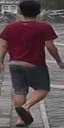

In [8]:
image

In [34]:
segmap,_ = S(transformed_image)
segmap = torch.argmax(segmap, dim = 1)

In [89]:
def tensor_to_pil(tensor):
    """
    Convert a normalized tensor to a PIL image.
    :param tensor: Normalized tensor (C, H, W).
    :return: PIL image.
    """
    tensor = tensor.squeeze(0)  # Remove batch dimension if exists
    tensor = tensor.permute(1, 2, 0).detach().cpu().numpy()
    tensor = (tensor * 0.5 + 0.5) * 255  # Assuming tensor was normalized to [-1, 1]
    tensor = tensor.astype(np.uint8)
    return Image.fromarray(tensor)

def tensor_to_pil(tensor):
    """
    Convert a normalized tensor to a PIL image, ensuring zero pixels remain zero.
    :param tensor: Normalized tensor (C, H, W).
    :return: PIL image.
    """
    tensor = tensor.squeeze(0)  # Remove batch dimension if exists
    tensor = tensor.permute(1, 2, 0).detach().cpu().numpy()
    
    # Denormalize: handle zero pixels separately
    denormalized = np.where(tensor == 0, 0, (tensor * 0.5 + 0.5) * 255)
    
    denormalized = denormalized.astype(np.uint8)
    return Image.fromarray(denormalized)

color_palette = [
    (0, 0, 0),        # Class 0: Black
    (255, 255, 255),      # Class 1: Red
    (0, 255, 0),      # Class 2: Green
    (0, 0, 255),      # Class 3: Blue
    (255, 255, 0),    # Class 4: Yellow
    (255, 0, 255)     # Class 5: Magenta
]

def apply_color_map(segmap, palette):
    """
    Apply a color map to a segmentation map.
    :param segmap: Segmentation map (H, W) with class indices.
    :param palette: Color palette as a list of RGB tuples.
    :return: Color-mapped image (H, W, 3).
    """
    h, w = segmap.shape
    color_image = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(palette):
        color_image[segmap == class_idx] = color
    return color_image

def visulize_mask(model, image_path, save_dir):
    target_size = (128, 256)
    image_path = image_path
    image_name = image_path.split('/')[-1]
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
    # Apply the transformations
    transformed_image = transform(image).to(device)
    transformed_image = transformed_image.unsqueeze(0)
    segmap,_ = model(transformed_image)
    segmap = torch.argmax(segmap, dim = 1)
    # Ensure the mask is broadcasted across the color channels
    mask_tensor = segmap.unsqueeze(1)  # Convert to shape (1, 1, 256, 256)
    mask_tensor = mask_tensor.repeat(1, 3, 1, 1)  # Convert to shape (1, 3, 256, 256)
  
    # Apply the mask to the image
    foreground_image = transformed_image * mask_tensor
    foreground_image = tensor_to_pil(foreground_image).resize(target_size)
    a_real_np = segmap.detach().cpu().numpy()
    a_real_color = apply_color_map(a_real_np[0], color_palette)
    a_real_seg_img = Image.fromarray(a_real_color)
    
    a_real_seg_img = a_real_seg_img.resize(target_size)
    image.save(save_dir + f'/{image_name}') 
    a_real_seg_img.save(save_dir + f'/mask_{image_name}')
    foreground_image.save(save_dir + f'/foreground_{image_name}')
    return foreground_image


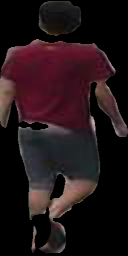

In [98]:
mask = visulize_mask(S,'/home/jun/ReID_Dataset/Market-1501-v15.09.15-stargan-1_2/Market-1501-v15.09.15-stargan-allcam/bounding_box_train/0002_c1s1_000551_01.jpg', '/home/jun/sample_image_for_SOICT2024')
mask

In [ ]:
def tensor_to_pil(tensor):
    """
    Convert a normalized tensor to a PIL image.
    :param tensor: Normalized tensor (C, H, W).
    :return: PIL image.
    """
    tensor = tensor.squeeze(0)  # Remove batch dimension if exists
    tensor = tensor.permute(1, 2, 0).detach().cpu().numpy()
    tensor = (tensor * 0.5 + 0.5) * 255  # Assuming tensor was normalized to [-1, 1]
    tensor = tensor.astype(np.uint8)
    return Image.fromarray(tensor)

def save_segmentation_maps(a_real_img, b_fake_img, 
                           a_real_segmap, b_fake_segmap, 
                           save_dir, epoch, i):
    # Ensure the segmentation maps are on the CPU and convert them to NumPy arrays
    a_real_np = a_real_segmap.detach().cpu().numpy()
    b_fake_np = b_fake_segmap.detach().cpu().numpy()

    # Apply color mapping to the segmentation maps
    a_real_color = apply_color_map(a_real_np[0], color_palette)
    b_fake_color = apply_color_map(b_fake_np[0], color_palette)

    # Convert the color-mapped arrays to PIL images
    a_real_seg_img = Image.fromarray(a_real_color)
    b_fake_seg_img = Image.fromarray(b_fake_color)

    # Denormalize and convert original images to PIL images
    mean = [0.5] * 3
    std = [0.5] * 3
    #a_real_pil_img = Image.fromarray((denormalize(a_real_img.squeeze(0).detach().cpu().clone(), mean, std).numpy().transpose(1, 2, 0) * 255).astype(np.uint8))
    #b_fake_pil_img = Image.fromarray((denormalize(b_fake_img.squeeze(0).detach().cpu().clone(), mean, std).numpy().transpose(1, 2, 0) * 255).astype(np.uint8))
    a_real_pil_img = tensor_to_pil(a_real_img)
    b_fake_pil_img = tensor_to_pil(b_fake_img)
   
    
    target_size = (128, 256)
    a_real_seg_img = a_real_seg_img.resize(target_size)
    b_fake_seg_img = b_fake_seg_img.resize(target_size)
    a_real_pil_img = a_real_pil_img.resize(target_size)
    b_fake_pil_img = b_fake_pil_img.resize(target_size)
    
    # Combine original images with their corresponding segmentation maps vertically
    a_real_combined = Image.new('RGB', (a_real_pil_img.width, a_real_pil_img.height + a_real_seg_img.height))
    b_fake_combined = Image.new('RGB', (b_fake_pil_img.width, b_fake_pil_img.height + b_fake_seg_img.height))

    
    a_real_combined.paste(a_real_pil_img, (0, 0))
    a_real_combined.paste(a_real_seg_img, (0, a_real_pil_img.height))
    b_fake_combined.paste(b_fake_pil_img, (0, 0))
    b_fake_combined.paste(b_fake_seg_img, (0, b_fake_pil_img.height))

    # Merge combined images horizontally
    merged_width = a_real_combined.width + b_fake_combined.width 
    merged_image = Image.new('RGB', (merged_width, a_real_combined.height))
    merged_image.paste(a_real_combined, (0, 0))
    merged_image.paste(b_fake_combined, (a_real_combined.width, 0))
   
    # Create the file name
    file_name = '%s/Epoch_(%d)_segmap_(%d).jpg' % (save_dir, epoch, i + 1)
    
    # Save the image
    merged_image.save(file_name)

In [8]:
def segmentation_augmentation(img_path, model):
        
    transform = transforms.Compose([
            transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    output = {}

    original = Image.open(img_path)
    w = original.size[0] 
    h = original.size[1]
    resize = transforms.Resize((h, w), interpolation=3)
    original_name = img_path.name
    output[img_path] = original
    
    # Transform image for model input
    img = transform(original).unsqueeze(0)
    img = img.to(next(model.parameters()).device)
    
    pred = model(img)
    if len(pred) == 2:
        pred,_ = pred 
    original = np.array(original)
    #output[original_name] = Image.fromarray(img.astype(np.uint8))
    pred = resize(pred) 
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8)
    output[None] = Image.fromarray(pred) 
       
    replace_dict = {0:'foreground', 1:'nohead', 2:'nobody', 3:'noarms', 4:'nolegs', 5:'nofeets'}
    for id, name in replace_dict.items():
        new_img = original.copy()
        new_img[pred == id] = [0.4914, 0.4822, 0.4465]
        new_img_name = original_name.replace(original_name.split('.')[0].split('_')[2],original_name.split('.')[0].split('_')[2] + name) 
        new_img_path = img_path.parent / new_img_name 
        output[new_img_path] = Image.fromarray(new_img.astype(np.uint8))
 
    return output